## Начало 

Проверим точность MobileNet V2.

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pickle
import methods

#from keras.callbacks import ModelCheckpoint

In [5]:
keras.callbacks

<module 'tensorflow._api.v1.keras.callbacks' from 'C:\\Users\\intern\\Anaconda3\\envs\\TensorFlowEnv\\lib\\site-packages\\tensorflow\\_api\\v1\\keras\\callbacks\\__init__.py'>

Зададим место, где лежат файлы.

In [6]:
DATA_FOLDER = "data"
CATEGORY_1 = "cat"
CATEGORY_2 = "dog"

## Взглянем на данные 

cat training data length:  7999
dog training data length:  7999
cat validation data length:  2001
dog validation data length:  2001
cat test data length:  2499
dog test data length:  2499


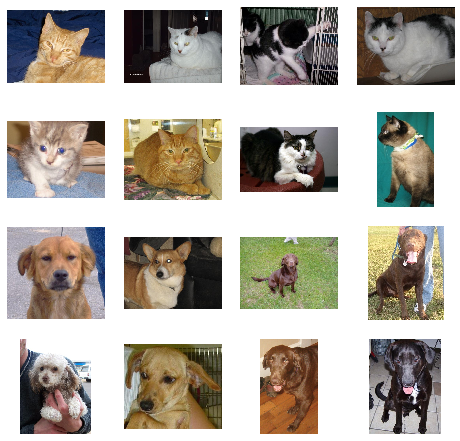

In [7]:
methods.visualize_data(DATA_FOLDER, CATEGORY_1, CATEGORY_2)

## Подготовим данные

In [8]:
image_size = 160 # All images will be resized to 150x150
batch_size = 4

train_datagen = ImageDataGenerator(rescale = 1/255)
validation_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
        DATA_FOLDER + '/train',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
        DATA_FOLDER + '/validation',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
        DATA_FOLDER + '/test',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        shuffle=False,
        class_mode = "binary"
)

Found 15998 images belonging to 2 classes.
Found 4002 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


## Построим и обучим модель 

In [5]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [6]:
base_model.trainable = False

In [7]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [8]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
epochs = 1
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [30]:
class TFCheckpointCallback(keras.callbacks.Callback):
    def __init__(self, saver, sess):
        self.saver = saver
        self.sess = sess

    def on_epoch_end(self, epoch, logs=None):
        self.saver.save(self.sess, 'freeze/checkpoint', global_step=epoch)

In [33]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        IMG_SHAPE = (image_size, image_size, 3)

        # Create the base model from the pre-trained model MobileNet V2
        base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                       include_top=False,
                                                       weights='imagenet')

        base_model.trainable = False

        model = tf.keras.Sequential([
          base_model,
          keras.layers.GlobalAveragePooling2D(),
          keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.summary()

        epochs = 1
        steps_per_epoch = train_generator.n // batch_size
        validation_steps = validation_generator.n // batch_size
        
        
        tf_graph = sess.graph
        # Ref: https://www.tensorflow.org/api_docs/python/tf/train/Saver
        tf_saver = tf.train.Saver()
        tfckptcb = TFCheckpointCallback(tf_saver, sess)

         # Write the protobuf graph
        # ref: https://www.tensorflow.org/api_docs/python/tf/train/write_graph
        tf.train.write_graph(tf_graph.as_graph_def(),
                             'freeze', 'graph.pbtxt', as_text=True)
        tf.train.write_graph(tf_graph.as_graph_def(),
                             'freeze', 'graph.pb', as_text=False)

        model.fit_generator(
              train_generator,
              steps_per_epoch = steps_per_epoch,
              epochs = epochs,
              workers = 4,
              validation_data = validation_generator,
              validation_steps = validation_steps,
              callbacks=[tfckptcb])
    


         # Initialize all variables


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/1
 189/3999 [>.............................] - ETA: 10:18 - loss: 0.6766 - acc: 0.5899

C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\intern\Anaconda

 999/3999 [======>.......................] - ETA: 7:45 - loss: 0.5260 - acc: 0.7412

C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


1476/3999 [==========>...................] - ETA: 6:31 - loss: 0.4821 - acc: 0.7703

C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 328728576 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 5357. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\intern\A

3998/3999 [============================>.] - ETA: 0s - loss: 0.4069 - acc: 0.8103

C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\intern\Anaconda3\envs\TensorFlowEn

3999/3999 [==============================] - 694s 174ms/step - loss: 0.4069 - acc: 0.8102 - val_loss: 0.1781 - val_acc: 0.9437


        init = tf.global_variables_initializer()
        sess.run(init)
        saver = tf.train.Saver()
        saver.save(sess,'models/mobileNetV2/tensorflowModel.ckpt')
        tf.train.write_graph(sess.graph.as_graph_def(), '.', 'tensorflowModel.pbtxt', as_text=True)

In [41]:
from tensorflow.python.platform import gfile
from tensorflow.python.framework.graph_util import convert_variables_to_constants

In [46]:
def freeze_graph(sess):
    # convert_variables_to_constants(sess, input_graph_def, output_node_names, variable_names_whitelist=None)
    with gfile.FastGFile("freeze/graph.pb", 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    frozen_graph_def = convert_variables_to_constants(sess, graph_def, ["output"])

    with tf.gfile.GFile("./tmp/" + "frozen.pb", "wb") as f:
        f.write(frozen_graph_def.SerializeToString())

    return frozen_graph_def

In [47]:
freeze_graph(sess)

AssertionError: output is not in graph

In [50]:
from tensorflow.python.tools import freeze_graph

In [52]:
freeze_graph.freeze_graph('models/mobileNetV2/frozen_model/tensorflowModel.pbtxt', "", True, 
                          'models/mobileNetV2/frozen_model/tensorflowModel.ckpt.meta', "output/sigmoid",
                           "save/restore_all", "save/Const:0",
                           'frozentensorflowModel.pb', True, ""  
                         )

DecodeError: Wrong wire type in tag.

In [73]:
saver = tf.train.import_meta_graph('models/mobileNetV2/frozen_model/tensorflowModel.ckpt.meta', clear_devices=True)
graph = tf.get_default_graph()
input_graph_def = graph.as_graph_def()
sess = tf.Session()
saver.restore(sess, "models/mobileNetV2/frozen_model/tensorflowModel.ckpt")

INFO:tensorflow:Restoring parameters from models/mobileNetV2/frozen_model/tensorflowModel.ckpt


In [78]:
output_node_names="out_relu"
output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess, # The session
            input_graph_def, # input_graph_def is useful for retrieving the nodes 
            output_node_names.split(",")  
)

AssertionError: out_relu is not in graph

In [75]:
output_graph="huinya.pb"
with tf.gfile.GFile(output_graph, "wb") as f:
    f.write(output_graph_def.SerializeToString())
 
sess.close()

In [61]:

frozen_graph="huinya.pb"
with tf.gfile.GFile(frozen_graph, "rb") as f:
    restored_graph_def = tf.GraphDef()
    restored_graph_def.ParseFromString(f.read())

In [62]:
 
with tf.Graph().as_default() as graph:
    tf.import_graph_def(
        restored_graph_def,
        input_map=None,
        return_elements=None,
        name=""
        )


ValueError: Input 0 of node mobilenetv2_1.00_160/bn_Conv1/cond/ReadVariableOp/Switch was passed float from bn_Conv1/gamma:0 incompatible with expected resource.

## Fine-tuning 

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

##  Сохраним результаты

Сохраним модель.

In [35]:
model.save("models/mobileNetV2/mobileNetV2.h5")

In [36]:
saved_model_path = "models/mobileNetV2/"
tf.contrib.saved_model.save_keras_model(model, saved_model_path)


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/mobileNetV2/1563491295\saved_model.pb


b'models/mobileNetV2/1563491295'

Сохраним историю обучения.

In [37]:
with open("histories/mobileNetV2/mobileNetV2History", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Сохраним историю fine-tuning обучения.

In [38]:
with open("histories/mobileNetV2/mobileNetV2HistoryFine", 'wb') as file_pi:
    pickle.dump(history_fine.history, file_pi)

Сделаем frozen graph.

## Восстановим результаты 

Восстановим модель.

In [3]:
model_loaded = keras.models.load_model("models/mobileNetV2/mobileNetV2.h5")

ValueError: Unknown layer: BatchNormalizationV1

Восстановим историю обучения.

In [40]:
with open("histories/mobileNetV2/mobileNetV2History", 'rb') as file_pi:
    history_loaded = pickle.load(file_pi)

Восстановим историю fine-tuning обучения.

In [41]:
with open("histories/mobileNetV2/mobileNetV2HistoryFine", 'rb') as file_pi:
    history_loaded_fine = pickle.load(file_pi)

## Посмотрим результаты 

Посмотрим графики обучения.

In [42]:
acc = history_loaded['acc']
val_acc = history_loaded['val_acc']
loss = history_loaded['loss']
val_loss = history_loaded['val_loss']

In [43]:
acc += history_loaded_fine['acc']
val_acc += history_loaded_fine['val_acc']

loss += history_loaded_fine['loss']
val_loss += history_loaded_fine['val_loss']

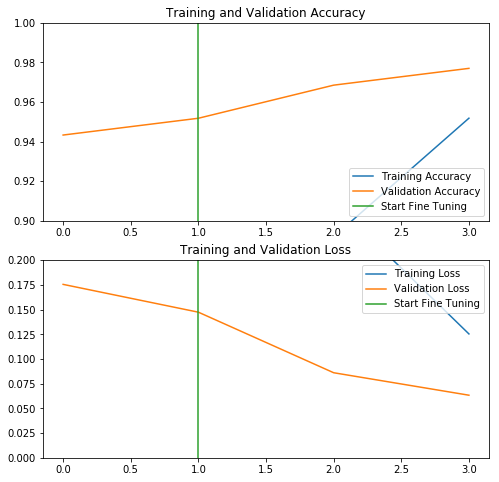

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Оценим параметры модели.

In [45]:
# Calculating accuracy, precision, recall, f1 score.
def AccRecPrec(predictions, test_labels):

    x = tf.placeholder(tf.int32, )
    y = tf.placeholder(tf.int32, )
    acc, acc_op = tf.metrics.accuracy(labels=x, predictions=y)
    rec, rec_op = tf.metrics.recall(labels=x, predictions=y)
    pre, pre_op = tf.metrics.precision(labels=x, predictions=y)
    f1,  f1_op  = tf.contrib.metrics.f1_score(labels=x, predictions=y)

    def f(x):
        if (x>0.5):
            return 1
        else:
            return 0
        
    predictions = np.array(list(map(f, predictions)))

    sess=tf.Session()
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    v = sess.run(acc_op, feed_dict={x: test_labels,y: predictions}) # Accuracy.
    r = sess.run(rec_op, feed_dict={x: test_labels,y: predictions}) # Recall.
    p = sess.run(pre_op, feed_dict={x: test_labels,y: predictions}) # Precision.
    f = sess.run(f1_op,  feed_dict={x: test_labels,y: predictions}) # F1.

    print("accuracy: ", v)
    print("recall:   ", r)
    print("precision:", p)
    print("f1:       ", 2*p*r/(p+r))

In [46]:
AccRecPrec(model_loaded.predict_generator(test_generator), test_generator.classes)

D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF d

accuracy:  0.97839135
recall:    0.9891957
precision: 0.9682726
f1:        0.9786223734465836
